In [28]:
# --- Data cleaning: run this first ---
import numpy as np
import pandas as pd

# If you already have df loaded from the URL, skip loading again.
# Otherwise uncomment the two lines below to load it:
# url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
# df = pd.read_csv(url)

# 1) Trim whitespace from object columns (common dirty data issue)
obj_cols = df.select_dtypes(include=['object']).columns
df[obj_cols] = df[obj_cols].apply(lambda x: x.str.strip())

# 2) Replace empty strings with NaN
df.replace('', np.nan, inplace=True)

# 3) Fix TotalCharges (often stored as string and has blanks). Convert to numeric.
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 4) For any missing TotalCharges, fill using a sensible rule:
#    If tenure > 0, use MonthlyCharges * tenure; else 0.
if 'TotalCharges' in df.columns and 'MonthlyCharges' in df.columns and 'tenure' in df.columns:
    df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])
    df['TotalCharges'] = df['TotalCharges'].fillna(0)

# 5) Drop duplicate customerIDs (if any) and reset index
if 'customerID' in df.columns:
    df.drop_duplicates(subset='customerID', inplace=True)
df.reset_index(drop=True, inplace=True)

# 6) Cast categorical columns to category dtype (helps later)
cat_cols = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService',
            'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
            'StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

# 7) Recreate TenureGroup (safe)
if 'tenure' in df.columns:
    bins = [0, 12, 24, 48, df['tenure'].max() + 1]
    labels = ['0-12 months', '1-2 years', '2-4 years', '4+ years']
    df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

# 8) Quick check of missing values
print("Missing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
TenureGroup         0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   int64   
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

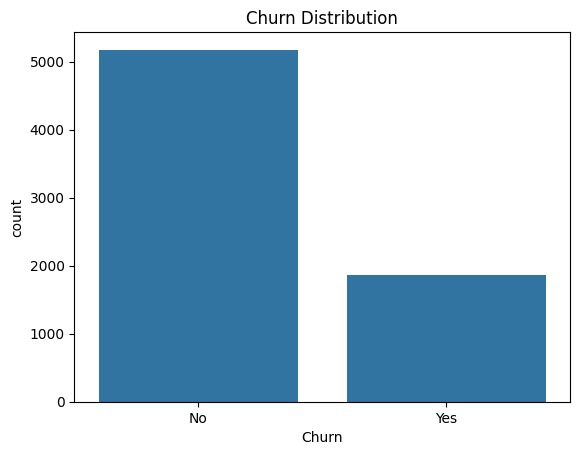

In [29]:
# Step 2: Quick Overview (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Column info and statistics
df.info()
df.describe()

# Churn distribution bar chart
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()


In [30]:
# Step 3: Total Customers & Churn Counts

# 1. Count total customers
total_customers = len(df)
print("Total customers:", total_customers)

# 2. Count churned vs active customers
churn_counts = df['Churn'].value_counts()
print("\nChurn counts:\n", churn_counts)


Total customers: 7043

Churn counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [31]:
# Step 4: Churn by Contract & Average Monthly Charges

# Churn rate by contract type
contract_churn = df.groupby('Contract')['Churn'].value_counts().unstack().fillna(0)
contract_churn['Churn Rate (%)'] = contract_churn['Yes'] / (contract_churn['Yes'] + contract_churn['No']) * 100
print("Churn by Contract Type:\n", contract_churn)

# Average monthly charges for churned vs retained
avg_monthly = df.groupby('Churn')['MonthlyCharges'].mean()
print("\nAverage Monthly Charges by Churn:\n", avg_monthly)


Churn by Contract Type:
 Churn             No   Yes  Churn Rate (%)
Contract                                  
Month-to-month  2220  1655       42.709677
One year        1307   166       11.269518
Two year        1647    48        2.831858

Average Monthly Charges by Churn:
 Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64


/tmp/ipython-input-688614196.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contract_churn = df.groupby('Contract')['Churn'].value_counts().unstack().fillna(0)
/tmp/ipython-input-688614196.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_monthly = df.groupby('Churn')['MonthlyCharges'].mean()


/tmp/ipython-input-1022924299.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Churn')['MonthlyCharges'].mean().plot(kind='bar')


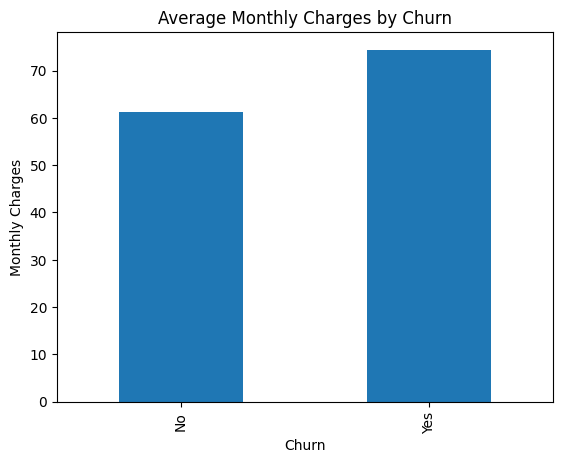

In [32]:
# Step 5: Visualizations

# Bar chart: Average Monthly Charges by Churn
df.groupby('Churn')['MonthlyCharges'].mean().plot(kind='bar')
plt.title('Average Monthly Charges by Churn')
plt.ylabel('Monthly Charges')
plt.show()


In [33]:
# Step 6a: Churn by Payment Method
payment_churn = df.groupby('PaymentMethod')['Churn'].value_counts().unstack().fillna(0)
payment_churn['Churn Rate (%)'] = payment_churn['Yes'] / (payment_churn['Yes'] + payment_churn['No']) * 100
print("Churn by Payment Method:\n", payment_churn)


Churn by Payment Method:
 Churn                        No   Yes  Churn Rate (%)
PaymentMethod                                        
Bank transfer (automatic)  1286   258       16.709845
Credit card (automatic)    1290   232       15.243101
Electronic check           1294  1071       45.285412
Mailed check               1304   308       19.106700


/tmp/ipython-input-3686086198.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payment_churn = df.groupby('PaymentMethod')['Churn'].value_counts().unstack().fillna(0)


In [34]:
# Step 6b: Churn by Internet Service
internet_churn = df.groupby('InternetService')['Churn'].value_counts().unstack().fillna(0)
internet_churn['Churn Rate (%)'] = internet_churn['Yes'] / (internet_churn['Yes'] + internet_churn['No']) * 100
print("Churn by Internet Service:\n", internet_churn)


Churn by Internet Service:
 Churn              No   Yes  Churn Rate (%)
InternetService                            
DSL              1962   459       18.959108
Fiber optic      1799  1297       41.892765
No               1413   113        7.404980


/tmp/ipython-input-3136162747.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  internet_churn = df.groupby('InternetService')['Churn'].value_counts().unstack().fillna(0)


In [35]:
# Step 7: Churn by Tenure Groups
# Create tenure ranges
bins = [0, 12, 24, 48, df['tenure'].max()]
labels = ['0-12 months', '1-2 years', '2-4 years', '4+ years']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

# Group by tenure and churn
tenure_churn = df.groupby('TenureGroup')['Churn'].value_counts().unstack().fillna(0)
tenure_churn['Churn Rate (%)'] = tenure_churn['Yes'] / (tenure_churn['Yes'] + tenure_churn['No']) * 100
print("Churn by Tenure Group:\n", tenure_churn)


Churn by Tenure Group:
 Churn          No  Yes  Churn Rate (%)
TenureGroup                           
0-12 months  1070  999       48.284195
1-2 years     738  309       29.512894
2-4 years    1285  339       20.874384
4+ years     1725  216       11.128284


/tmp/ipython-input-3814933521.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df.groupby('TenureGroup')['Churn'].value_counts().unstack().fillna(0)


In [36]:
# Step 8: Revenue Lost Due to Churn
lost_revenue = df[df['Churn'] == 'Yes']['MonthlyCharges'].sum()
print("Total Monthly Charges Lost Due to Churn:", lost_revenue)


Total Monthly Charges Lost Due to Churn: 139130.85


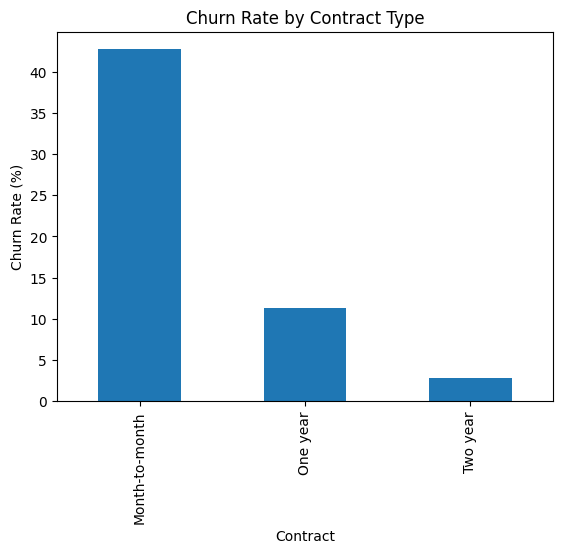

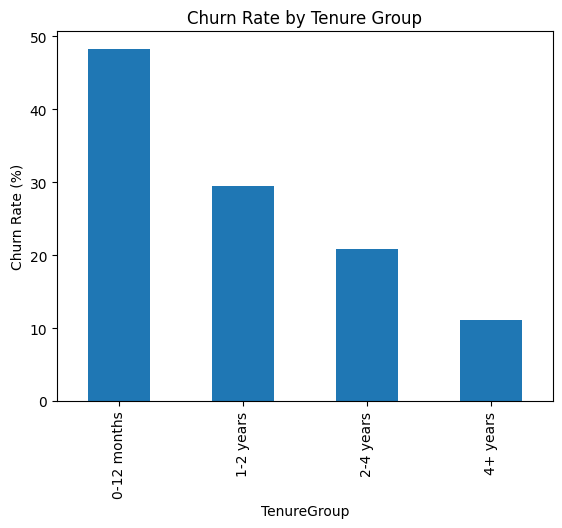

In [37]:
# Step 9a: Churn Rate by Contract (Bar Chart)
contract_churn['Churn Rate (%)'].plot(kind='bar')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate (%)')
plt.show()

# Step 9b: Churn Rate by Tenure Group (Bar Chart)
tenure_churn['Churn Rate (%)'].plot(kind='bar')
plt.title('Churn Rate by Tenure Group')
plt.ylabel('Churn Rate (%)')
plt.show()


/tmp/ipython-input-1117402217.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payment_churn = df.groupby('PaymentMethod')['Churn'].value_counts().unstack().fillna(0)
/tmp/ipython-input-1117402217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_churn.index, y=payment_churn['Churn Rate (%)'], palette="coolwarm")


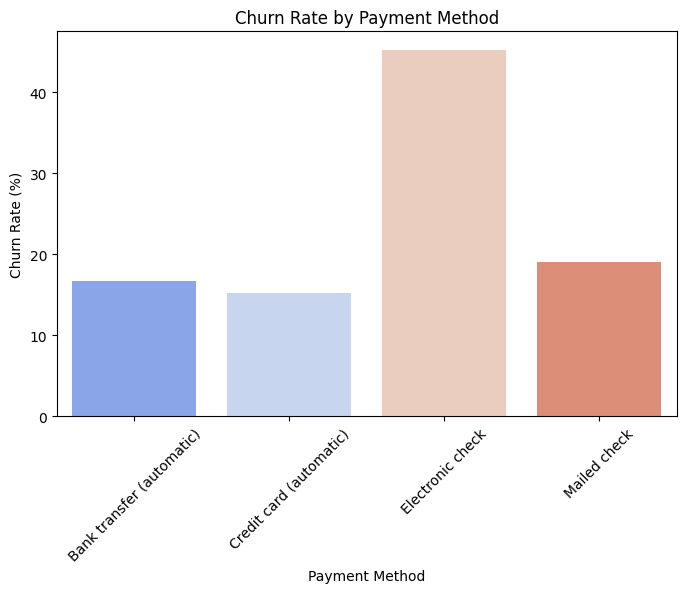

In [38]:
# Step 10a: Churn Rate by Payment Method
payment_churn = df.groupby('PaymentMethod')['Churn'].value_counts().unstack().fillna(0)
payment_churn['Churn Rate (%)'] = payment_churn['Yes'] / (payment_churn['Yes'] + payment_churn['No']) * 100

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=payment_churn.index, y=payment_churn['Churn Rate (%)'], palette="coolwarm")
plt.title('Churn Rate by Payment Method')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Payment Method')
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-173656872.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  internet_churn = df.groupby('InternetService')['Churn'].value_counts().unstack().fillna(0)
/tmp/ipython-input-173656872.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=internet_churn.index, y=internet_churn['Churn Rate (%)'], palette="viridis")


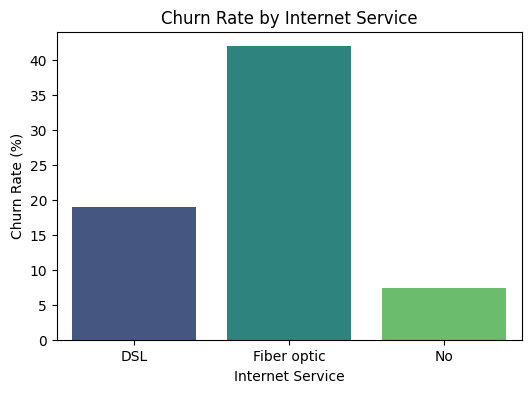

In [39]:
# Step 10b: Churn Rate by Internet Service
internet_churn = df.groupby('InternetService')['Churn'].value_counts().unstack().fillna(0)
internet_churn['Churn Rate (%)'] = internet_churn['Yes'] / (internet_churn['Yes'] + internet_churn['No']) * 100

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=internet_churn.index, y=internet_churn['Churn Rate (%)'], palette="viridis")
plt.title('Churn Rate by Internet Service')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Internet Service')
plt.show()


/tmp/ipython-input-664168179.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tenure_churn['Churn Rate (%)'], y=tenure_churn.index, palette="magma")


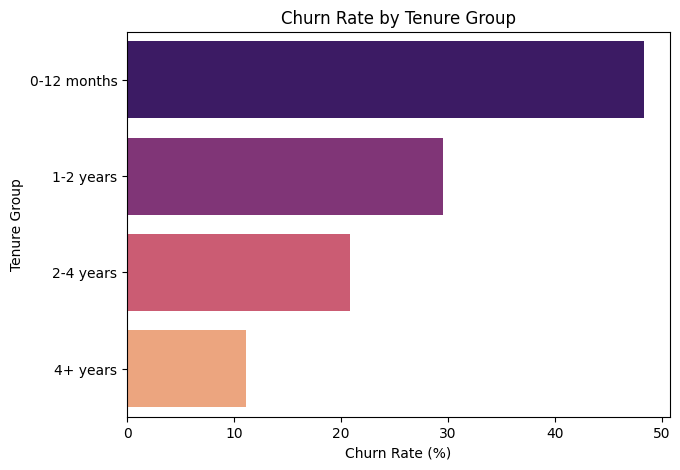

In [40]:
# Step 10c: Churn Rate by Tenure Group (Horizontal Bar)
plt.figure(figsize=(7,5))
sns.barplot(x=tenure_churn['Churn Rate (%)'], y=tenure_churn.index, palette="magma")
plt.title('Churn Rate by Tenure Group')
plt.xlabel('Churn Rate (%)')
plt.ylabel('Tenure Group')
plt.show()


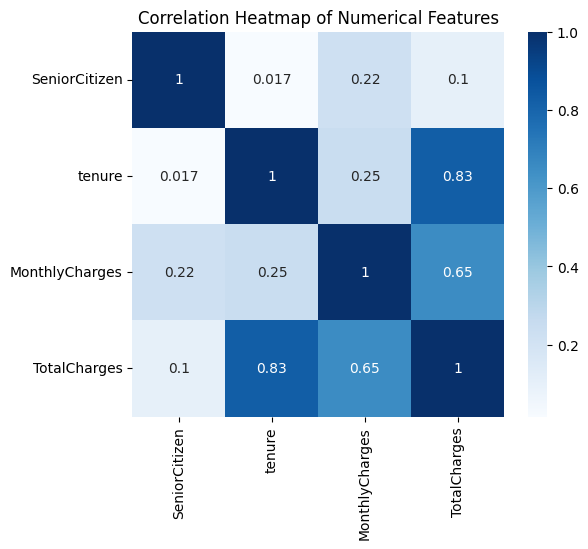

In [41]:
# Step 10d: Correlation Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap="Blues")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


# Final Insights: Customer Churn Analysis

## 1. Overall Churn
- Total customers: **7,043**  
- Churned customers: **1,869**  
- Overall churn rate: **26.54%**  
- 💡 **Insight:** About **1 in 4 customers** leaves the company, showing that customer retention is a significant challenge.

---

## 2. Revenue Lost Due to Churn
- Total monthly revenue lost from churned customers: **$139,130.85**  
- 💡 **Insight:** Churn has a direct financial impact, highlighting the importance of retention strategies.

---

## 3. Churn by Contract Type
| Contract Type     | No Churn | Yes Churn | Churn Rate (%) |
|------------------|----------|-----------|----------------|
| Month-to-month   | 2220     | 1655      | 42.71          |
| One year         | 1307     | 166       | 11.27          |
| Two year         | 1647     | 48        | 2.83           |

- 💡 **Insight:** Customers on **short-term (month-to-month) contracts** are far more likely to churn than long-term contracts.  
- Long-term contracts are effective for customer retention.

---

## 4. Churn by Tenure Group
| Tenure Group    | No Churn | Yes Churn | Churn Rate (%) |
|-----------------|----------|-----------|----------------|
| 0-12 months     | 1070     | 999       | 48.28          |
| 1-2 years       | 738      | 309       | 29.51          |
| 2-4 years       | 1285     | 339       | 20.87          |
| 4+ years        | 1725     | 216       | 11.13          |

- 💡 **Insight:** **New customers churn the most**, nearly 50% in their first year.  
- Retention improves as tenure increases, showing the importance of customer onboarding.

---

## 5. Churn by Payment Method
| Payment Method             | No Churn | Yes Churn | Churn Rate (%) |
|-----------------------------|----------|-----------|----------------|
| Bank transfer (automatic)  | 1286     | 258       | 16.71          |
| Credit card (automatic)    | 1290     | 232       | 15.24          |
| Electronic check           | 1294     | 1071      | 45.29          |
| Mailed check               | 1304     | 308       | 19.11          |

- 💡 **Insight:** Customers paying by **electronic check** churn at very high rates (45%).  
- Auto-pay methods (credit card, bank transfer) help reduce churn significantly.

---

## 6. Churn by Internet Service
| Internet Service | No Churn | Yes Churn | Churn Rate (%) |
|------------------|----------|-----------|----------------|
| DSL              | 1962     | 459       | 18.96          |
| Fiber optic      | 1799     | 1297      | 41.89          |
| No service       | 1413     | 113       | 7.40           |

- 💡 **Insight:** **Fiber optic customers churn the most**, suggesting dissatisfaction with pricing or service quality.  
- Customers without internet service are the least likely to churn.

---

## 7. Average Monthly Charges by Churn
- Customers who churn: **$74.44** average  
- Customers who stay: **$61.27** average  

- 💡 **Insight:** Customers paying higher monthly charges are more likely to churn, which suggests pricing sensitivity among customers.

---

## 8. Correlation Heatmap (Numerical Features)
- **MonthlyCharges** is negatively correlated with **tenure** → newer customers often have higher charges.  
- **Tenure** and **churn** are also negatively correlated → long-term customers are less likely to churn.  
- 💡 **Insight:** Billing practices and early pricing strongly influence churn.

---

## 9. Key Takeaways
- Focus retention on **month-to-month customers** and those in their **first year**.  
- Encourage **long-term contracts** and **automatic payments** to stabilize churn.  
- Investigate **fiber optic service** issues to reduce dissatisfaction.  
- Address **high monthly charges** for new customers through discounts or loyalty programs.  
- Even small reductions in churn could save the company **over $100,000 per month** in lost revenue.


### 📌 Acknowledgment  

This project was completed as part of my capstone/learning experience in data analysis.  
While I was responsible for running the code, organizing the workflow, and preparing the deliverables,  
I received significant guidance from **ChatGPT (OpenAI)** throughout the process.  

The assistance included:  
- Step-by-step explanations of data analysis methods  
- Support in writing and debugging Python and SQL code  
- Help in interpreting the results and structuring insights  
- Suggestions for documenting and presenting the findings clearly  

This collaboration allowed me to better understand the concepts and successfully carry out the project.  
Any mistakes or limitations in the analysis are entirely my responsibility.  
